In [2]:
import pandas as pd
import mysql.connector
import os

In [10]:
# List of CSV files 
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('geolocation.csv', 'geolocation'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments') 
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root101',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:\\Target sales'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    

    df = pd.read_csv(file_path)
    

    df = df.where(pd.notnull(df), None)
    

    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")


    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame 
    for _, row in df.iterrows():

        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)


    conn.commit()


conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_descrip

In [29]:
# Using Python to take the data to SQL
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

In [30]:
db = mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = 'root101',
                             database = 'ecommerce')
cur = db.cursor()

 1. List all unique cities where customers are located.

In [31]:
query = """select distinct(customer_city) from customers"""
cur.execute(query)
data = cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

2. Count the number of customers from each state. 

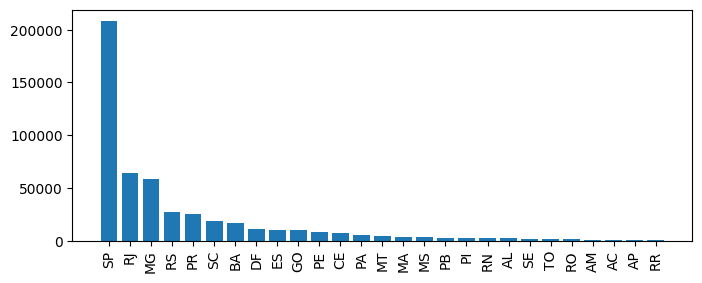

In [32]:
query = """select customer_state, count(customer_id)
from customers
group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["state","customer_count"])
df = df.sort_values(by= "customer_count", ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

3. Calculate the percentage of orders that were paid in installments.

In [33]:
 query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

4. Identify the correlation between product price and the number of times a product has been purchased.

In [34]:
cur = db.cursor()
query = """ select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

In [35]:
arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157556


5. Calculate the total revenue generated by each seller, and rank them by revenue.

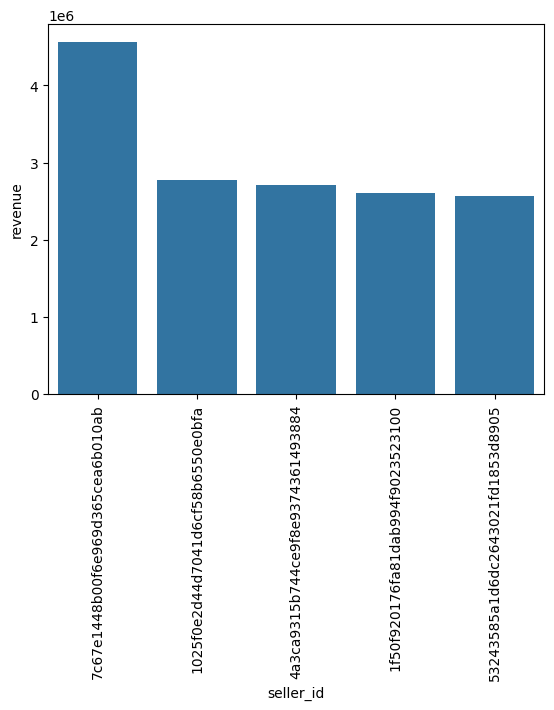

In [39]:
query = """ select *, dense_rank() over(order by revenue desc) as rn
from(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as A"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["seller_id", "revenue","rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

6. Calculate the cumulative sales per month for each year.

In [40]:
query = """ select years,months,payment, sum(payment)
over(order by years,months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years,months order by years,months) as b"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,3783.60,3.783600e+03
1,2016,10,886357.20,8.901408e+05
2,2016,12,294.30,8.904351e+05
3,2017,1,2077320.60,2.967756e+06
4,2017,2,4378620.14,7.346376e+06
5,2017,3,6747953.99,1.409433e+07
6,2017,4,6266820.44,2.036115e+07
7,2017,5,8893782.30,2.925493e+07
8,2017,6,7669145.70,3.692408e+07
9,2017,7,8885743.79,4.580982e+07


7. Identify the top 5 customers who spent the most money in each year.

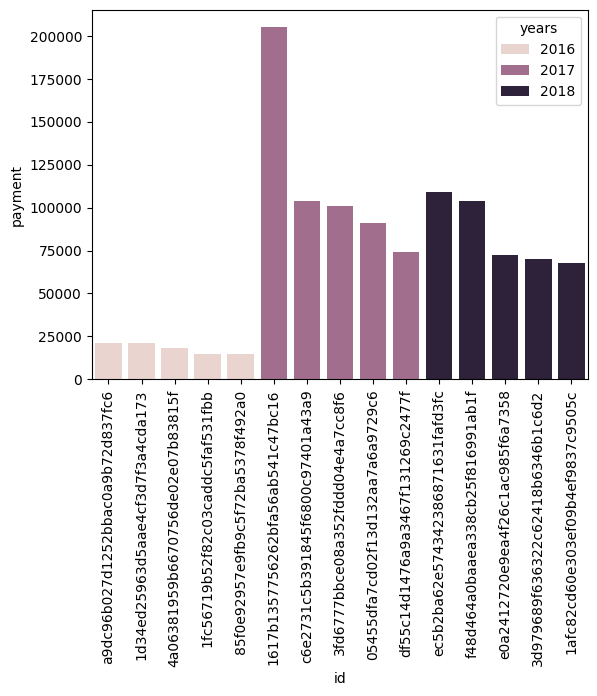

In [44]:
query = """ select years, customer_id, payment, d_rank
from (select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as c 
where d_rank <= 5"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years", "id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()